# Image classification with Convolutional Neural Networks

We'll build and train a neural network to classify images of clothing like sneakers and shirts. We'll use keras from TensorFlow.

# Install and import dependencies

We'll need TensorFlow datasets, which simplifies downloading and accessing datasets and provides several sample datasets to work with and we'll use a few helper libraries.

In [ ]:
!pip install -U tensorflow_datasets

     |████████████████████████████████| 3.7MB 10.7MB/s 
  Found existing installation: tensorflow-datasets 4.0.1
    Uninstalling tensorflow-datasets-4.0.1:
      Successfully uninstalled tensorflow-datasets-4.0.1


In [ ]:
import tensorflow as tf

#import tensorflow datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

#helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Import the fashion MNIST dataset

The fashion MNIST dataset contains 70000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution, 28x28 pixels.

We will use 60000 images to train the network and 10000 images to evaluate how accurately the network learned to classify images.

In [ ]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


Loading the dataset returns metadata as well as training datadest and test dataset.
* The model is trained using train_dataset.
* The model is tested against the test_dataset.
The images are 28x28 pixels with pixels values in the range [0, 255]. The labels are an array of integers in the range [0, 9] These correspond to the class of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the class names are not included with the dataset, store them here to use later when plotting the images.

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Explore the data

Let's explore the format of the dataset before training the model. The following shows there are 60000 images in the training set and 10000 images in the test set:

In [ ]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of testing examples: {}".format(num_test_examples))

Number of training examples: 60000
Number of testing examples: 10000


# Preprocess the data

The value of each pixel in the image is in the range [0, 255]. For the model to work properly, these values need to be normalized to the range [0,1]. So here we create a normalization function, then apply it to each image in the test and train datasets.

In [ ]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train and test datasets
train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

# The first time you use the dataset the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset = train_dataset.cache()
test_dataset = test_dataset.cache()

# Explore the processed data

We'll plot an image to see what it looks like.

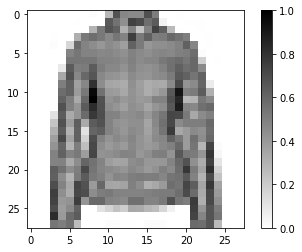

In [ ]:
# Take a single image and remove the color dimension by reshaping

for image,label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Plot the image
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

Let's display the first 25 images from the training set and display the class name below each image. Verify that the data is in the correct format and we're ready to build and train the network.

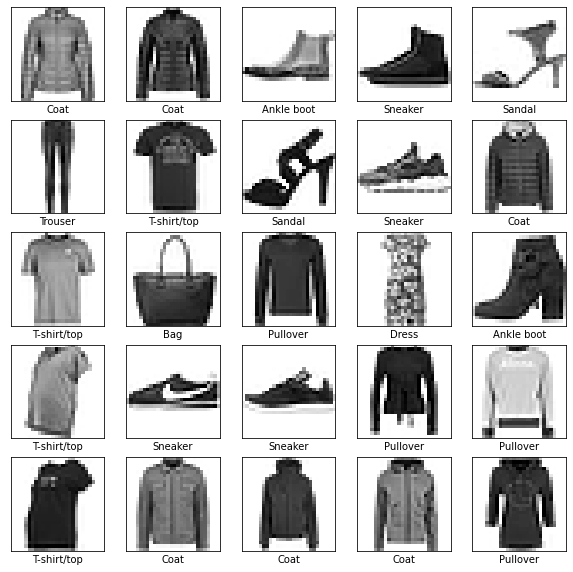

In [ ]:
plt.figure(figsize=(10, 10))
i = 0
for(image, label) in test_dataset.take(25):
  image = image.numpy().reshape((28,28))
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image, cmap=plt.cm.binary)
  plt.xlabel(class_names[label])
  i += 1
plt.show()

# Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

## Setup the layers

The basic building block of a neural network is the layer. A layer extracts a representation from the data fed into it. Hopefully, a series of connected layers results in a representation that is meaningful for the problem at hand.

Much of deep learning consists of chaining together simple layers. Most layers, like `tf.keras.layers.Dense`, have internal parameters which are adjusted (learned) during training.

In [ ]:
model = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu, input_shape=(28,28,1)),
                             tf.keras.layers.MaxPooling2D((2,2), strides=2),
                             tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu),
                             tf.keras.layers.MaxPooling2D((2,2), strides=2),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(128, activation=tf.nn.relu),
                             tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

These network layers are:

* **convolutions** `tf.keras.layersConv2D and MaxPooling2D` - The network starts with two pairs of Conv/MaxPool. The first layer is a Conv2D, filters (3,3) are being applied to the input image, retaining the original image size by using padding and creating 32 output (convulted) images (so this layer creates 32 convulted images of the same size as input). After that, the 32 outputs are reduced in size using a MaxPooling2D (2,2) with a stride of 2. The next Conv2D also has a (3,3) kernel, takes the 32 images as input and creates 64 outputs which are again reduced in size by a MaxPooling2D layer.
* **output** `tf.keras.layers.Dense` - A 128-neuron, followed by a 10-node softmax layer. Each node represents a class of clothing. As in the previous layer, the final layer takes input from the 128 nodes in the layer before it and outputsa value in the range [0, 1], representing the probability that the image belongs to that class. The sum of all 10 node values is 1.

>Using `softmax`activation and `SparseCategoricalCrossentropy()` has issues and which are patched by the `tf.keras`model. A safer approach, in general, is to use a linear output (no activation function) with `SparseCategoricalCrossentropy(from_logits=True)`.

# Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:
* loss function - an algorithm for measuring how far the model's outputs are from the desired output. The goal of training is this measures loss
optimizer - an algorithm for adjusting the inner parameters of the model in order to minimize loss
metrics - used to monitor the training and testing steps; the following is using accuracy, the fraction of the images that are correctly classified

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Train the model

First we define the iteration behavior for the train dataset:
1. Repeat forever by specifying `dataset.repeat()` (the epochs parameter described below limits how long we perform training).
2. The `dataset.shuffle(60000)` randomizes the order so our model cannot learn anything from the order of the examples.
3. The `dataset.batch(32)` tells `model.fit` to use batches of 32 images and labels when updating the model variables.

Training is performed by calling the `model.fit` method:
1. Feed the training data to the model using `train_dataset`.
2. The model learns to associate images and labels.
3. The `epochs=5` parameter limits training to 5 full iterations of the training dataset, so a total of 5*60000 = 300000 examples.

In [ ]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [ ]:
model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/10
1875/1875 [==============================] - 18s 4ms/step - loss: 0.5863 - accuracy: 0.7900
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2847 - accuracy: 0.8972
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2418 - accuracy: 0.9102
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2117 - accuracy: 0.9241
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1849 - accuracy: 0.9328
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1585 - accuracy: 0.9407
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1437 - accuracy: 0.9458
Epoch 8/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1261 - accuracy: 0.9526
Epoch 9/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1112 - accuracy: 0.9575
Epoch 10/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.10

# Evaluate accuracy

Next, compare how the model performs on the test dataset. Use all examples we have in the test dataset to asses accuracy.

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/BATCH_SIZE))
print('Accuracy on test dataset: ', test_accuracy)

313/313 [==============================] - 2s 6ms/step - loss: 0.2668 - accuracy: 0.9202
Accuracy on test dataset:  0.920199990272522


As it turns out, the accuracy on the test dataset is smaller than the accuracy on the training dataset. This is completely normal, since the model was trained on `train_dataset`. Whne the model sees images it has never seen before (during training), we can expect performance to go down.

# Make predictions and explore

With the model trained, we can use it to make predictions about some images.

In [ ]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [ ]:
predictions.shape

(32, 10)

Here, the model has predicted the probability of each label for each image in the testing set. Let's take a look at the first prediction.

In [ ]:
predictions[0]

array([2.9498522e-05, 1.2060535e-07, 1.9092460e-03, 1.5202452e-10,
       6.8374336e-01, 2.2228016e-07, 3.1431472e-01, 9.5693620e-10,
       1.0798680e-09, 2.8517136e-06], dtype=float32)

A prediction is an array of 10 numbers. These describe the "confidence" of the model that the image corresponds to each of the 10 different articles of clothing. We can see which label has the highest confidence value:

In [ ]:
np.argmax(predictions[0])

4

Let's chech the label to see which article of clothing it is.

In [ ]:
test_labels[0]

4

We can graph this to look at the full set of 10 class predictions

In [ ]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Let's look at the 0th image, predictions and prediction array.

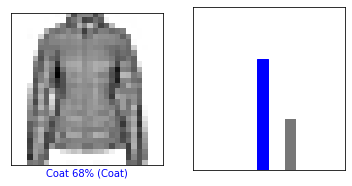

In [ ]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

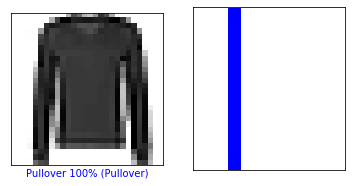

In [ ]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

Let's plot several images with their predictions. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percent (out of 100) for the predicted label. Note that it can be wrong even when very confident.

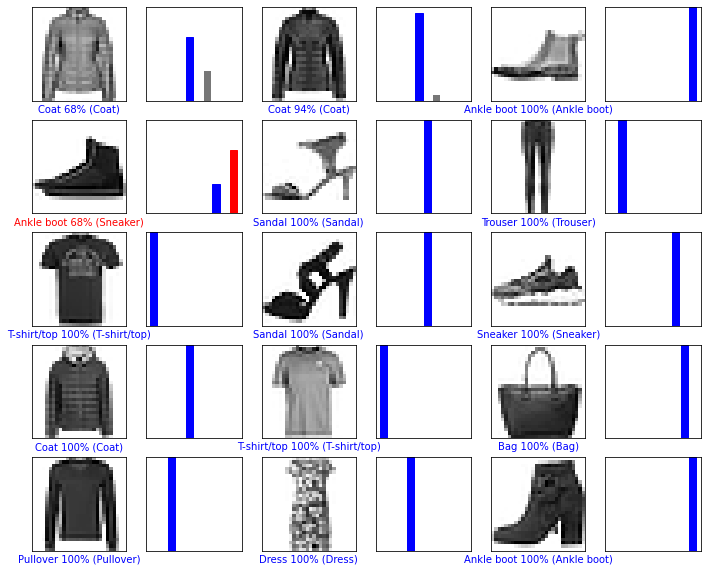

In [ ]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

Finally, use the trained model to make a prediction about a single image.

In [ ]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28, 1)


tf.keras models are optimized to make predictions on a batch, or collection, of examples at once. So even though we're using a single image, we need to add it to a list

In [ ]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


Now predict the image:

In [ ]:
predictions_single = model.predict(img)

print(predictions_single)

[[2.9498438e-05 1.2060535e-07 1.9092453e-03 1.5202424e-10 6.8374336e-01
  2.2227997e-07 3.1431472e-01 9.5693253e-10 1.0798659e-09 2.8517111e-06]]


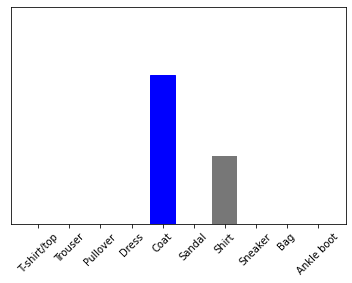

In [ ]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

`model.predict` returns a list of lists, one for each image in the batch of data. Grab the predictions for our (only) image in the batch:

In [ ]:
np.argmax(predictions_single[0])

4